##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 前置準備

下面三塊都先執行



## Preparation

Let's start with installing MediaPipe.


In [ ]:
!pip install -q mediapipe==0.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 33.3 MB/s eta 0:00:00


Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#models) for more information about this model bundle.

In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

## 畫關節點跟骨架的 Function
`draw_landmarks_on_image()`

In [ ]:
#To better demonstrate the Pose Landmarker API, we have created a set of visualization tools that will be used in this colab. These will draw the landmarks on a detect person, as well as the expected connections between those markers.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]
  # pose_landmarks = detection_result.pose_landmarks

  # Draw the pose landmarks.
  pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
  pose_landmarks_proto.landmark.extend([
    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
  ])
  solutions.drawing_utils.draw_landmarks(
    annotated_image,
    pose_landmarks_proto,
    solutions.pose.POSE_CONNECTIONS,
    solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

## Running inference and visualizing the results

The final step is to run pose landmark detection on your selected image. This involves creating your PoseLandmarker object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/python) to learn more about configuration options that this solution supports.


## 下面這一些是影片的處理
<font color="yellow">我有標編號 #1 ~ #4</font>

<font color="yellow">每一塊都可以獨立跑，看你想要的 output 是什麼</font>

<font color="yellow">就跑哪一塊！</font>

# 處理影片#1

input : 影片

output : 一堆圖片，黑色背景 with 骨架

output direcotory : `./skeletons_black_background`


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os

# Initialize MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# Initialize the Pose model
with mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.1,
    smooth_landmarks=True) as pose:

    video_path = 'clip.mp4'
    cap = cv2.VideoCapture(video_path)

    output_folder = 'skeletons_black_background'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    frame_index = 0
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break

        # Dynamically create a black background based on the current frame size
        image_height, image_width, _ = image.shape
        black_background = np.zeros((image_height, image_width, 3), dtype=np.uint8)

        # Process the image and get pose landmarks
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Check if any landmarks were detected
        if not results.pose_landmarks:
            continue

        # Use the dynamically created black background
        annotated_image = black_background.copy()

        # Draw pose landmarks on the black background
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

        # Save the annotated image
        cv2.imwrite(os.path.join(output_folder, f'annotated_image_{frame_index:06d}.png'), annotated_image)

        frame_index += 1

    cap.release()


# 處理影片#2

input : 影片

output : 一堆圖片，黑底 白 segment withOUT 骨架

output directory : `./masks_withOUT_skeleton`

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:
BG_COLOR = (0, 0, 0) # gray
# 這邊填參數
with mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.1,
    smooth_landmarks=True) as pose:
  video_path = 'clip.mp4'
  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  output_folder = 'masks_withOUT_skeleton'
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)

  frame_index = 0
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      break
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue

    # annotated_image = image.copy()
    # # Draw segmentation on the image.
    # # To improve segmentation around boundaries, consider applying a joint
    # # bilateral filter to "results.segmentation_mask" with "image".
    # condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    # bg_image = np.zeros(image.shape, dtype=np.uint8)
    # bg_image[:] = BG_COLOR
    # annotated_image = np.where(condition, annotated_image, bg_image)
    # # cv2_imshow(annotated_image)

    #########
    segmentation_mask = results.segmentation_mask
    visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
    # cv2_imshow(visualized_mask)
    #########


    # # Draw pose landmarks on the image.
    # mp_drawing.draw_landmarks(
    #     visualized_mask,
    #     results.pose_landmarks,
    #     mp_pose.POSE_CONNECTIONS,
    #     landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    # Save annotated image
    cv2.imwrite(os.path.join(output_folder, f'annotated_image_{frame_index:06d}.png'), visualized_mask)
    # cv2_imshow(annotated_image)

    frame_index += 1

  cap.release()

# 處理影片#3

input : 影片

output : 一堆圖片，黑底、白 segment WITH 骨架

output directory : `./masks_with_skeleton`


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:
BG_COLOR = (0, 0, 0) # gray
# 這邊填參數
with mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.1,
    smooth_landmarks=True) as pose:
  video_path = 'clip.mp4'
  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  output_folder = 'masks_with_skeleton'
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)

  frame_index = 0
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      break
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue

    # annotated_image = image.copy()
    # # Draw segmentation on the image.
    # # To improve segmentation around boundaries, consider applying a joint
    # # bilateral filter to "results.segmentation_mask" with "image".
    # condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    # bg_image = np.zeros(image.shape, dtype=np.uint8)
    # bg_image[:] = BG_COLOR
    # annotated_image = np.where(condition, annotated_image, bg_image)
    # # cv2_imshow(annotated_image)

    #########
    segmentation_mask = results.segmentation_mask
    visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
    # cv2_imshow(visualized_mask)
    #########


    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        visualized_mask,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    # Save annotated image
    cv2.imwrite(os.path.join(output_folder, f'annotated_image_{frame_index:06d}.png'), visualized_mask)
    # cv2_imshow(annotated_image)

    frame_index += 1

  cap.release()

# 處理影片#4

input : 影片

output : 一堆圖片，去背人(有臉有身體有衣服) WITH 骨架

output directory : `./color_images`

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:
BG_COLOR = (0, 0, 0) # gray
# 這邊填參數
with mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.1,
    smooth_landmarks=True) as pose:
  video_path = 'clip.mp4'
  cap = cv2.VideoCapture(video_path)
  fps = cap.get(cv2.CAP_PROP_FPS)
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  output_folder = 'color_images'
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)

  frame_index = 0
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      break
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue

    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)

    # Draw pose landmarks on the image.
    # mp_drawing.draw_landmarks(
    #     annotated_image,
    #     results.pose_landmarks,
    #     mp_pose.POSE_CONNECTIONS,
    #     landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    # Save annotated image
    cv2.imwrite(os.path.join(output_folder, f'annotated_image_{frame_index:06d}.png'), annotated_image)
    # cv2_imshow(annotated_image)

    frame_index += 1

  cap.release()


---

# <font color="red">以下所有幾塊不用看</red>
就是我留著方便看東西

# 這也是處理影片
output 是一個影片
人被藍藍的 mask 覆蓋
上面畫骨架

In [ ]:
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a pose landmarker instance with the video mode:
options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='pose_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO)


# 下面這塊是處理圖片
你不需要理他，只是 in case 你會用到

output 是人類去背圖片 with 骨架


Nose coordinates: (325.18970489501953, 121.50741577148438)


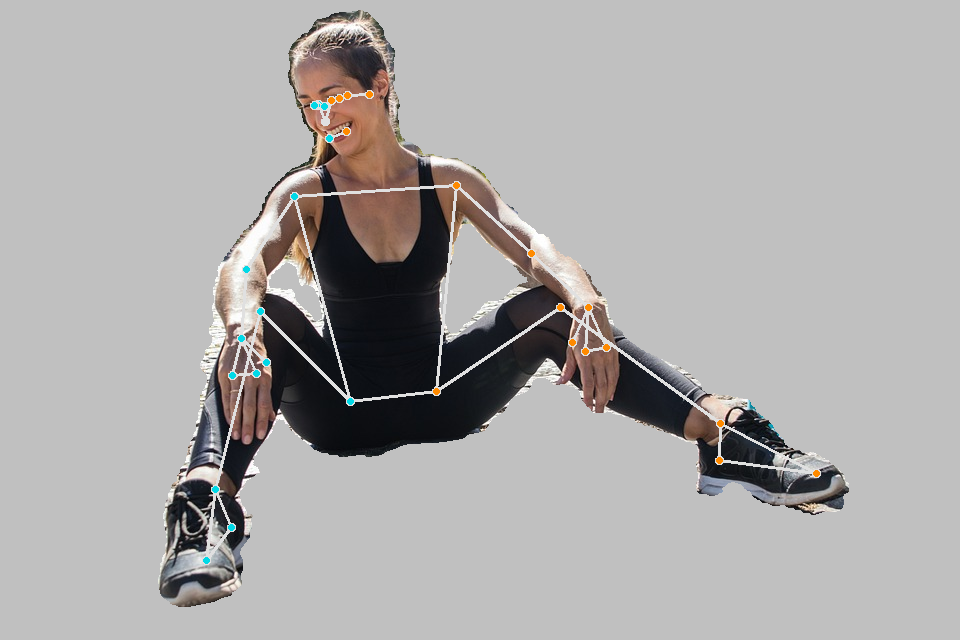

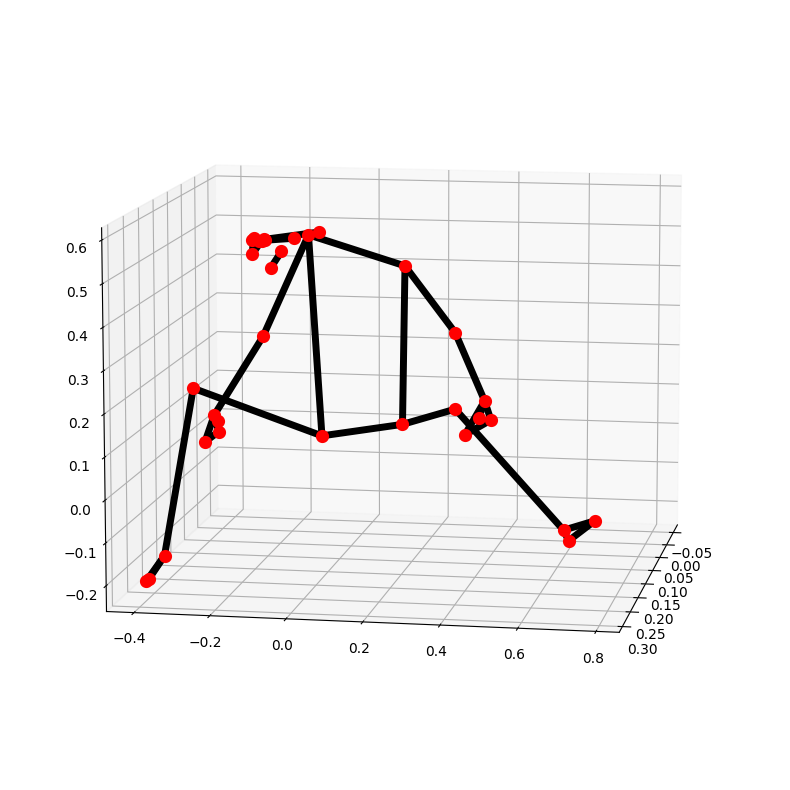

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For static images:

# 注意喔！!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# IMAGE_FILES 是一個 string List
# 裡面的 string 是所有需要處理的 images 的 File

# 如果有很多張 images，檔案名稱編號又是連續的
# IMAGE_FILES = [f"image-0{i}.jpeg" for i in range(85, 93)]

# 如果有只有一張 image
IMAGE_FILES = ["image.jpg"]

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


BG_COLOR = (192, 192, 192) # gray
# 這邊填參數
with mp_pose.Pose(
    static_image_mode=False,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.1,
    smooth_landmarks=True) as pose:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue
    print(
        f'Nose coordinates: ('
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
    )

    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)

    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
    cv2_imshow(annotated_image)
    # Plot pose world landmarks.
    mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)


# 下面這塊也是處理圖片

output 是原本圖片 with 骨架


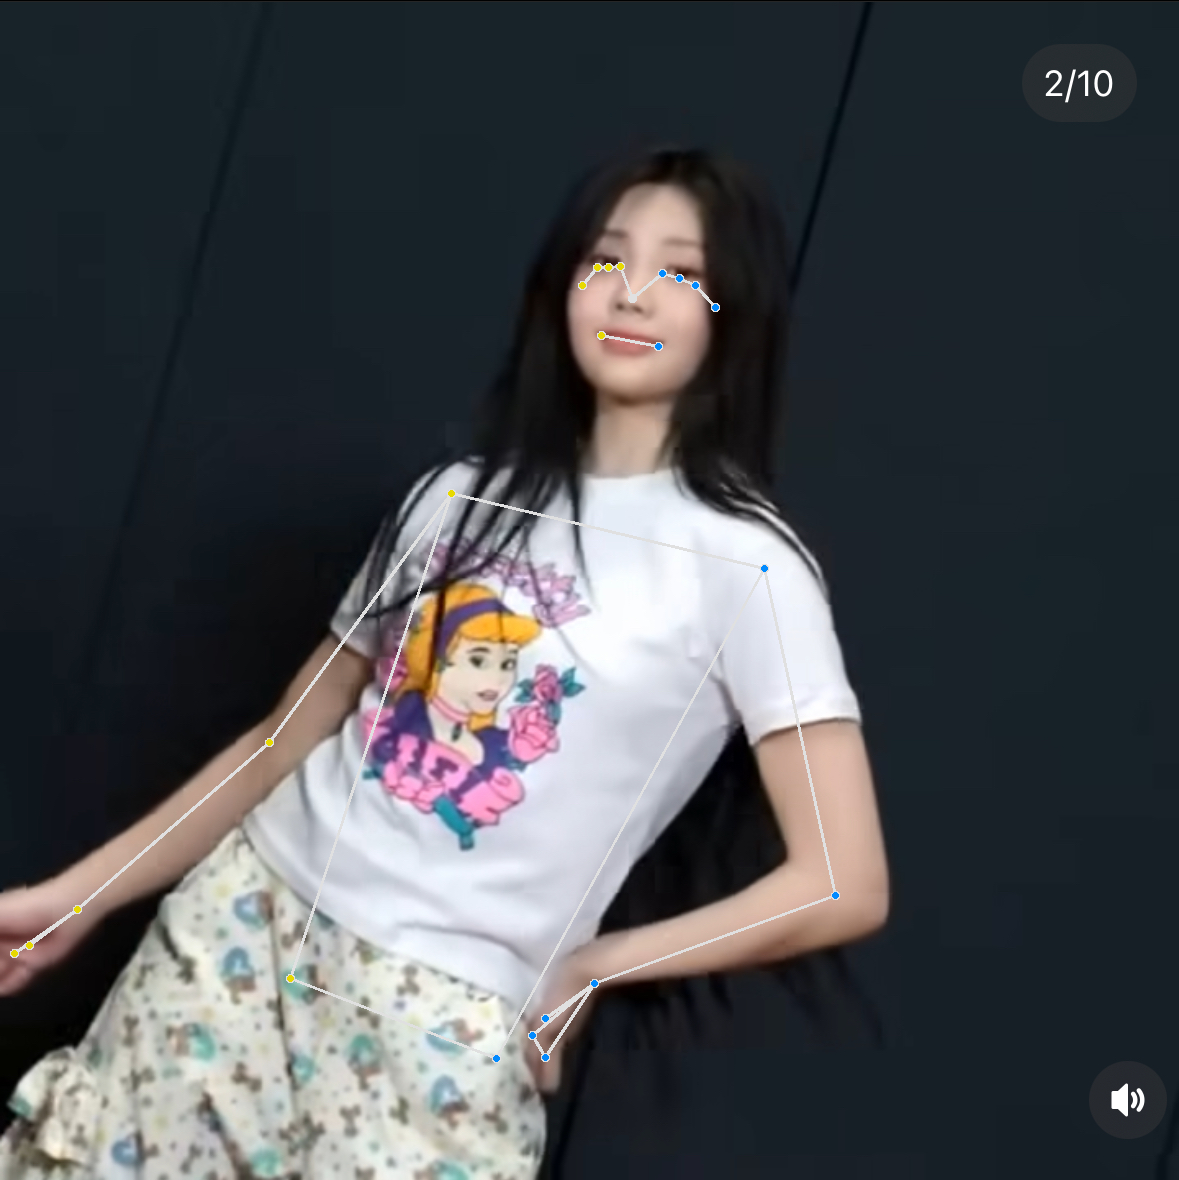

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Visualize the pose segmentation mask.
展示 mask

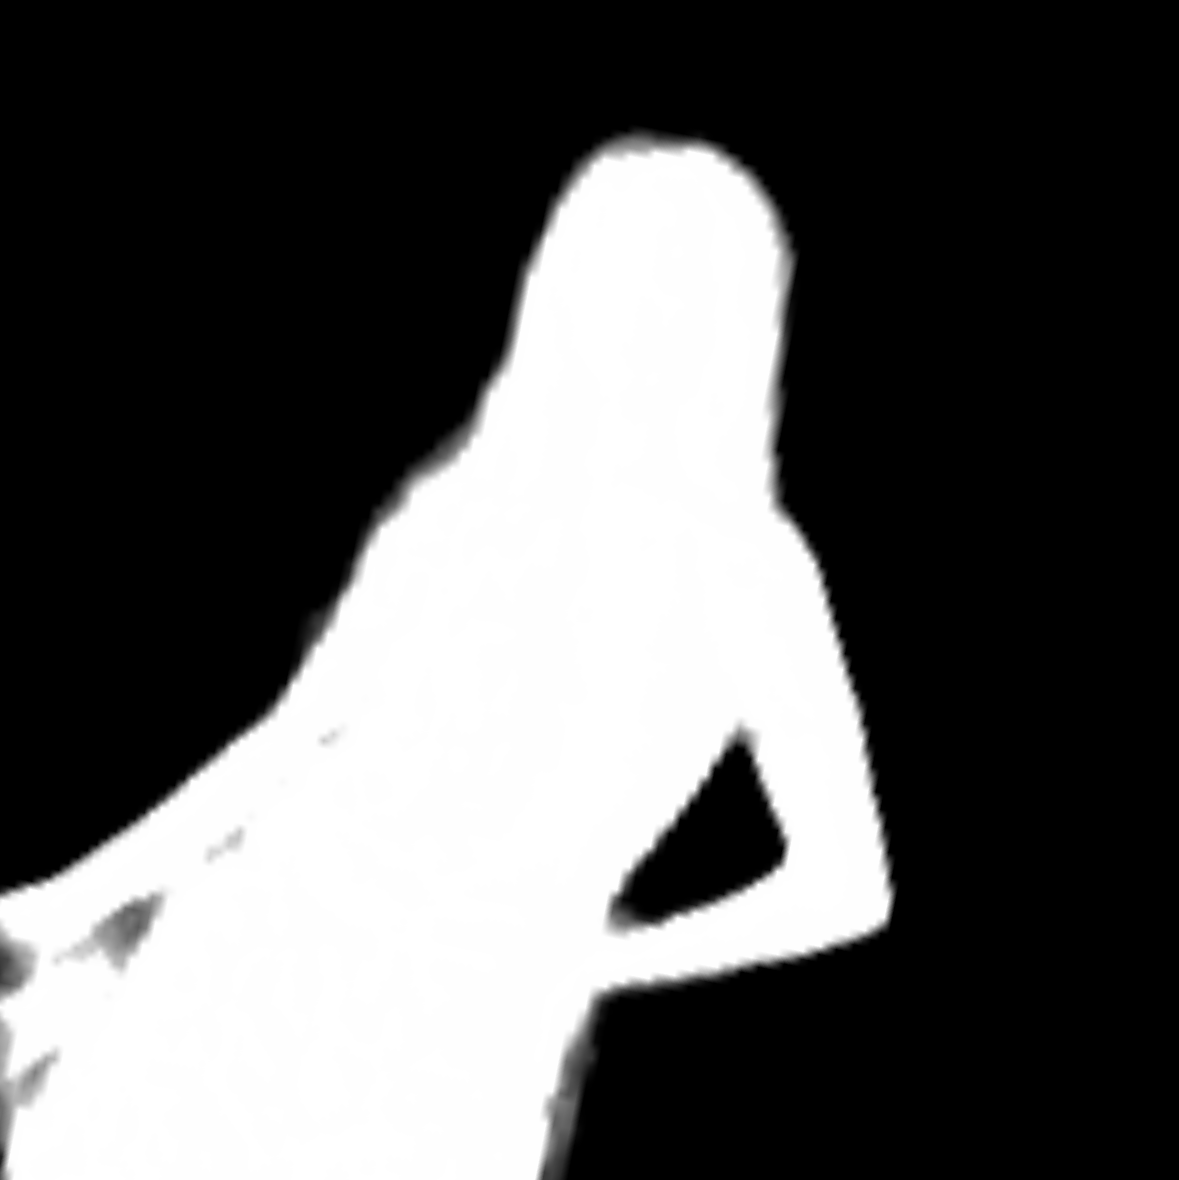

In [ ]:
segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
cv2_imshow(visualized_mask)